In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml

# Set the home directory
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [2]:
# Create the necessary folder structure for the dataset
def create_folder_structure(base_path):
    folders = [
        'data/train/images', 'data/train/labels',
        'data/val/images', 'data/val/labels',
        'data/test/images', 'data/test/labels'
    ]
    for folder in folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)

create_folder_structure(HOME)

In [3]:
# Convert bounding box coordinates
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    return (x * dw, y * dh, w * dw, h * dh)

# Convert XML annotations to YOLO format
def convert_annotation(xml_path, output_path, classes):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(output_path, 'w') as out_file:
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult) == 1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            bb = convert_bbox((w, h), b)
            out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")

In [4]:
# Process the dataset and organize files
def process_dataset(dataset_path, output_path):
    classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
    
    image_folder = os.path.join(dataset_path, 'images')
    annotation_folder = os.path.join(dataset_path, 'annotations')
    
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    
    # Split the dataset
    train_val, test = train_test_split(image_files, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)
    
    # Process and move files
    for split, files in [('train', train), ('val', val), ('test', test)]:
        for file in files:
            # Image
            src_img = os.path.join(image_folder, file)
            dst_img = os.path.join(output_path, f'data/{split}/images', file)
            shutil.copy(src_img, dst_img)
            
            # Annotation
            xml_file = os.path.splitext(file)[0] + '.xml'
            src_xml = os.path.join(annotation_folder, xml_file)
            dst_txt = os.path.join(output_path, f'data/{split}/labels', os.path.splitext(file)[0] + '.txt')
            convert_annotation(src_xml, dst_txt, classes)
    
    # Create data.yaml
    yaml_content = {
        'train': f'{HOME}/data/train/images',
        'val': f'{HOME}/data/val/images',
        'test': f'{HOME}/data/test/images',
        'nc': len(classes),
        'names': classes
    }
    
    with open(os.path.join(output_path, 'data', 'data.yaml'), 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file, default_flow_style=False)

# Define dataset path and output path
dataset_path = '/kaggle/input/face-mask-detection'
output_path = f'{HOME}/'

# Process the dataset
process_dataset(dataset_path, output_path)
print("Dataset preparation completed.")

Dataset preparation completed.


In [6]:
# Install YOLOv10
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [7]:
# Necessary package installations
!pip install -q supervision 
!pip uninstall -y wandb
!pip install -q --upgrade huggingface_hub

Found existing installation: wandb 0.17.4
Uninstalling wandb-0.17.4:
  Successfully uninstalled wandb-0.17.4


In [8]:
# Download YOLOv10 weights
!mkdir -p {HOME}/weights
weights = ['yolov10n.pt', 'yolov10s.pt', 'yolov10m.pt', 'yolov10b.pt', 'yolov10x.pt', 'yolov10l.pt']
base_url = 'https://github.com/THU-MIG/yolov10/releases/download/v1.1/'
for weight in weights:
    !wget -P {HOME}/weights -q {base_url + weight}
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


/kaggle/working
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/1 /kaggle/working/data/train/images/maksssksksss709.png: 640x512 1 person, 81.2ms
Speed: 13.3ms preprocess, 81.2ms inference, 262.4ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


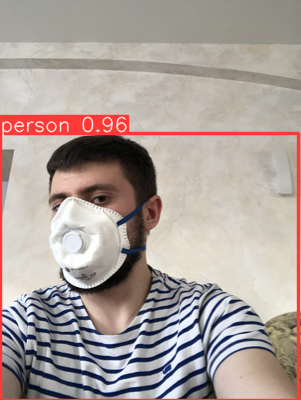

In [9]:
# Predict using the YOLOv10 model
%cd {HOME}
!yolo task=detect mode=predict conf=0.25 save=True \
model={HOME}/weights/yolov10n.pt \
source={HOME}/data/train/images/maksssksksss709.png

# Display the prediction image
from IPython.display import Image
Image(filename='runs/detect/predict/maksssksksss706.png', height=600)

In [10]:
# Train the YOLOv10 model
%cd {HOME}
!yolo task=detect mode=train epochs=100 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={HOME}/data/data.yaml

/kaggle/working
New https://pypi.org/project/ultralytics/8.2.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/data/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

F1_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch1620.jpg
P_curve.png					   train_batch1621.jpg
R_curve.png					   train_batch1622.jpg
args.yaml					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
confusion_matrix_normalized.png			   val_batch0_pred.jpg
events.out.tfevents.1724735727.c32e99d3665c.156.0  val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


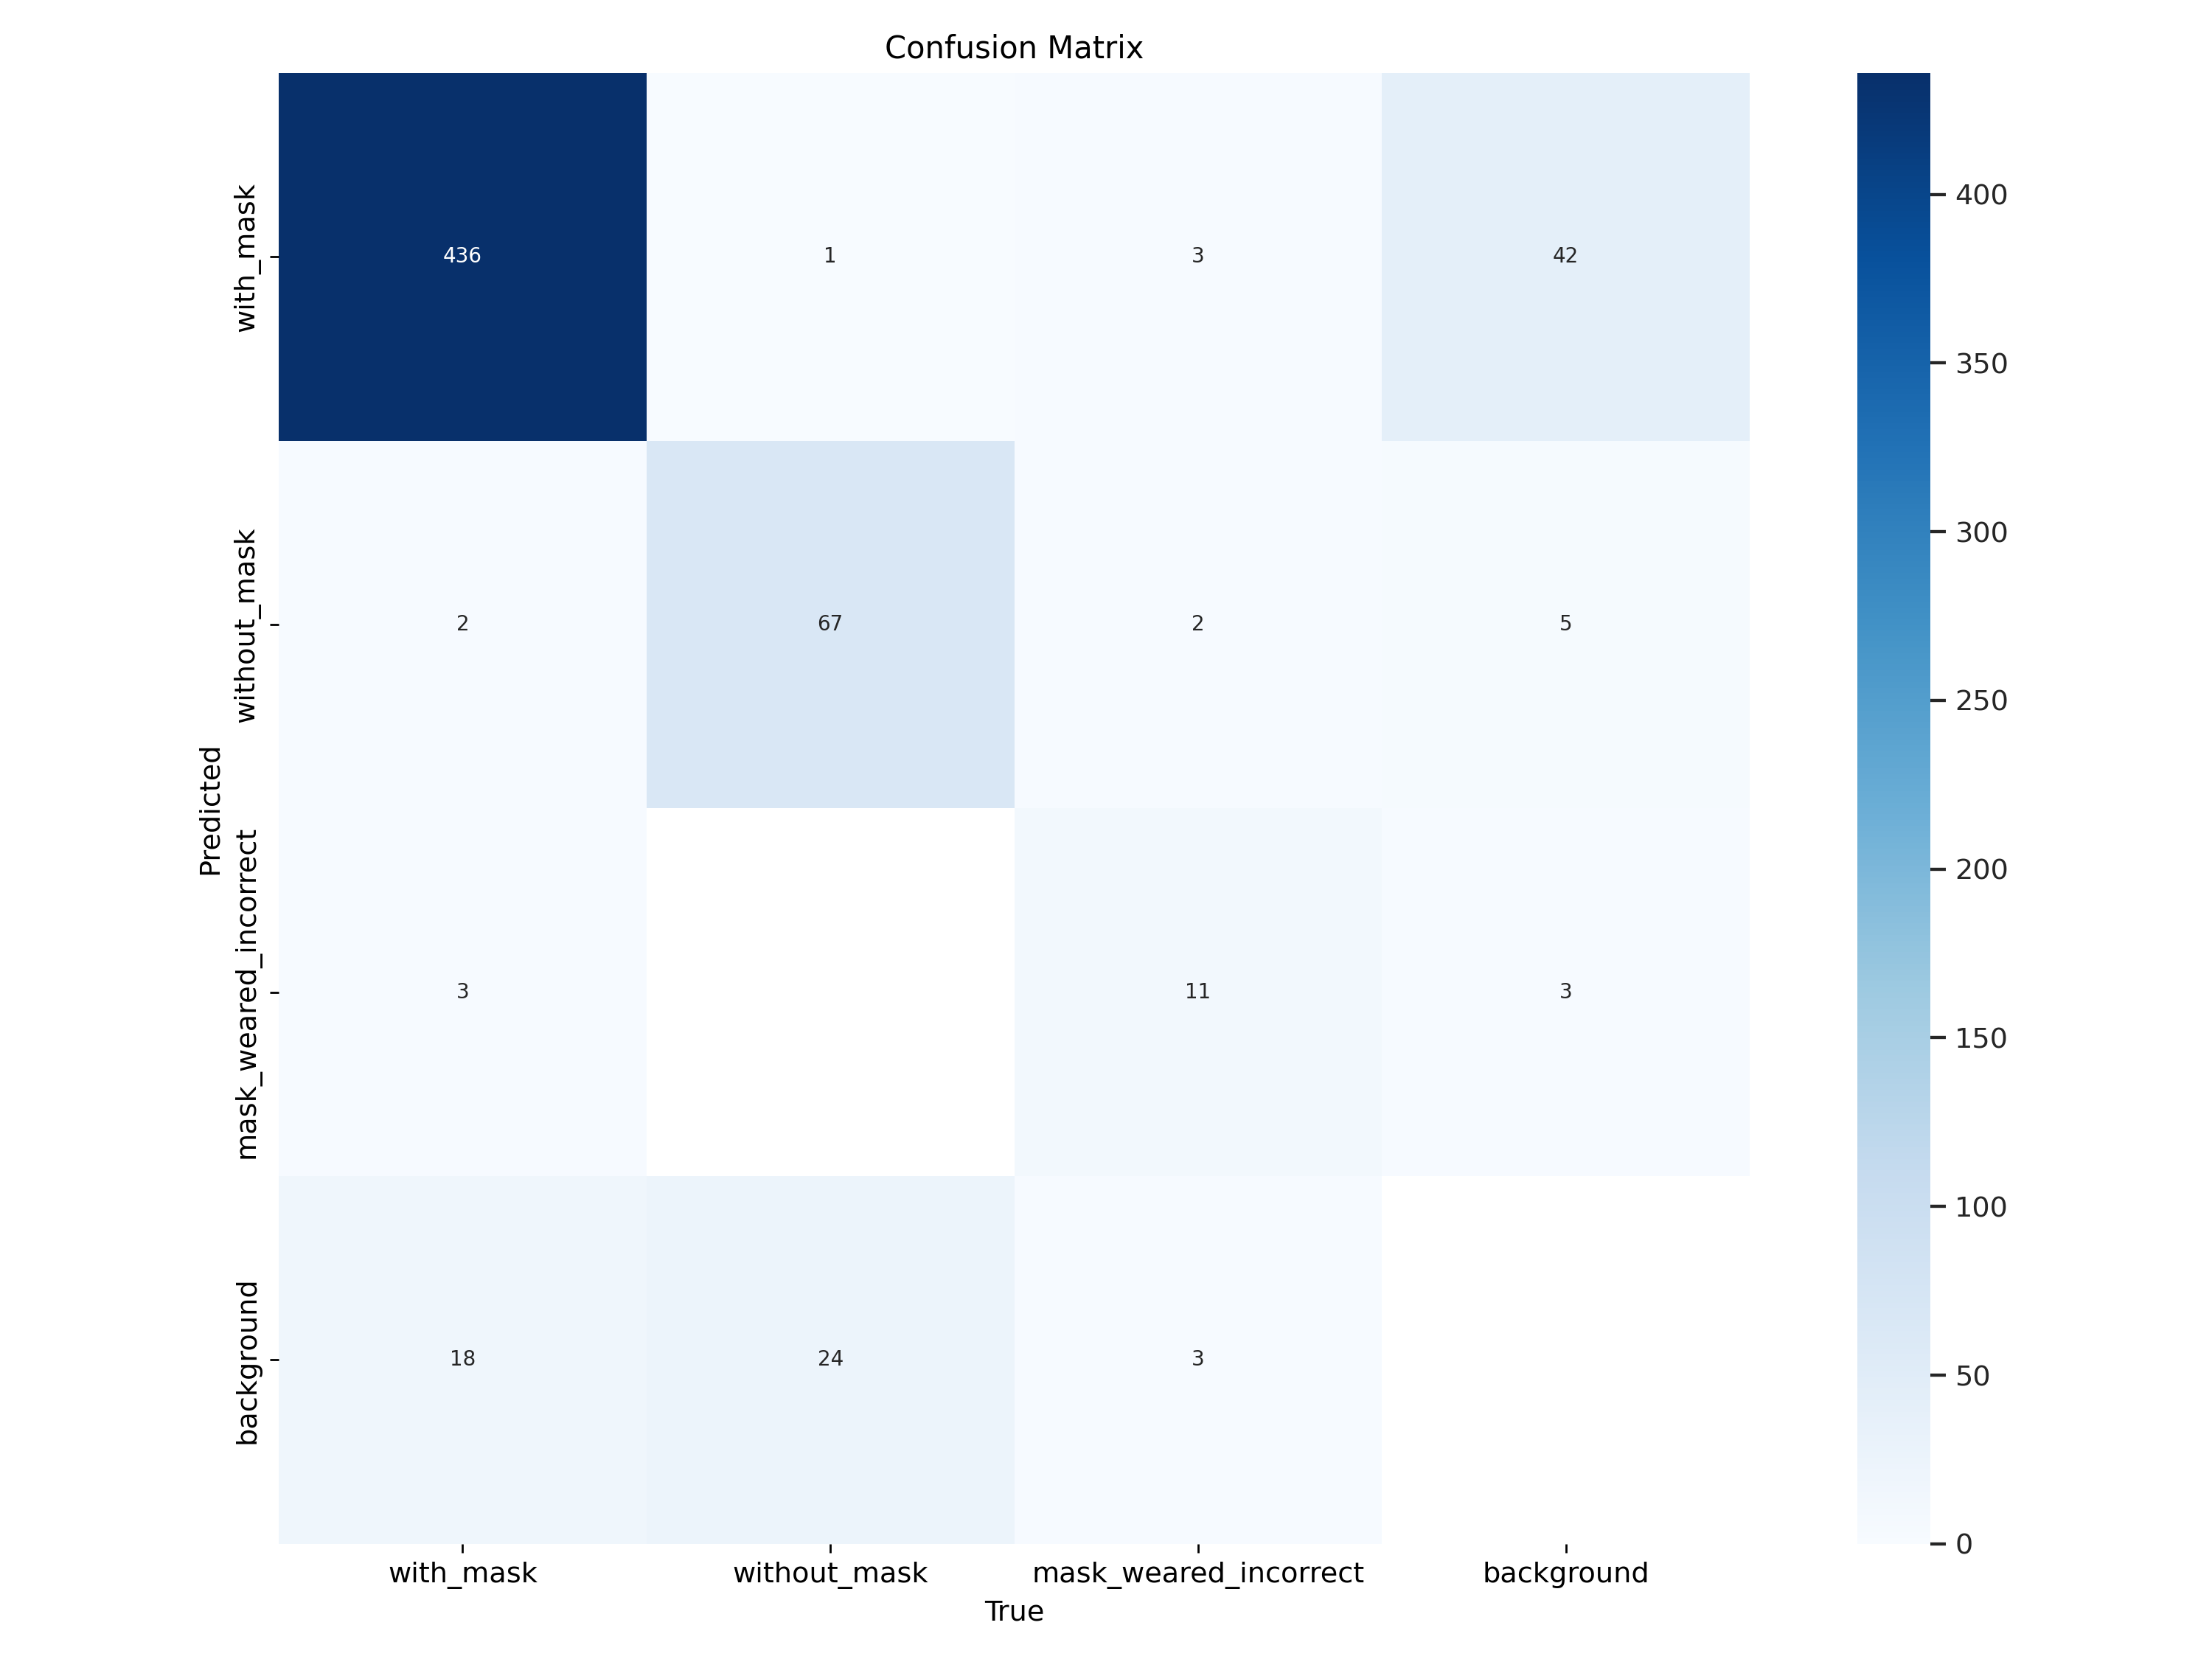

In [11]:
# Display training results
!ls {HOME}/runs/detect/train/

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

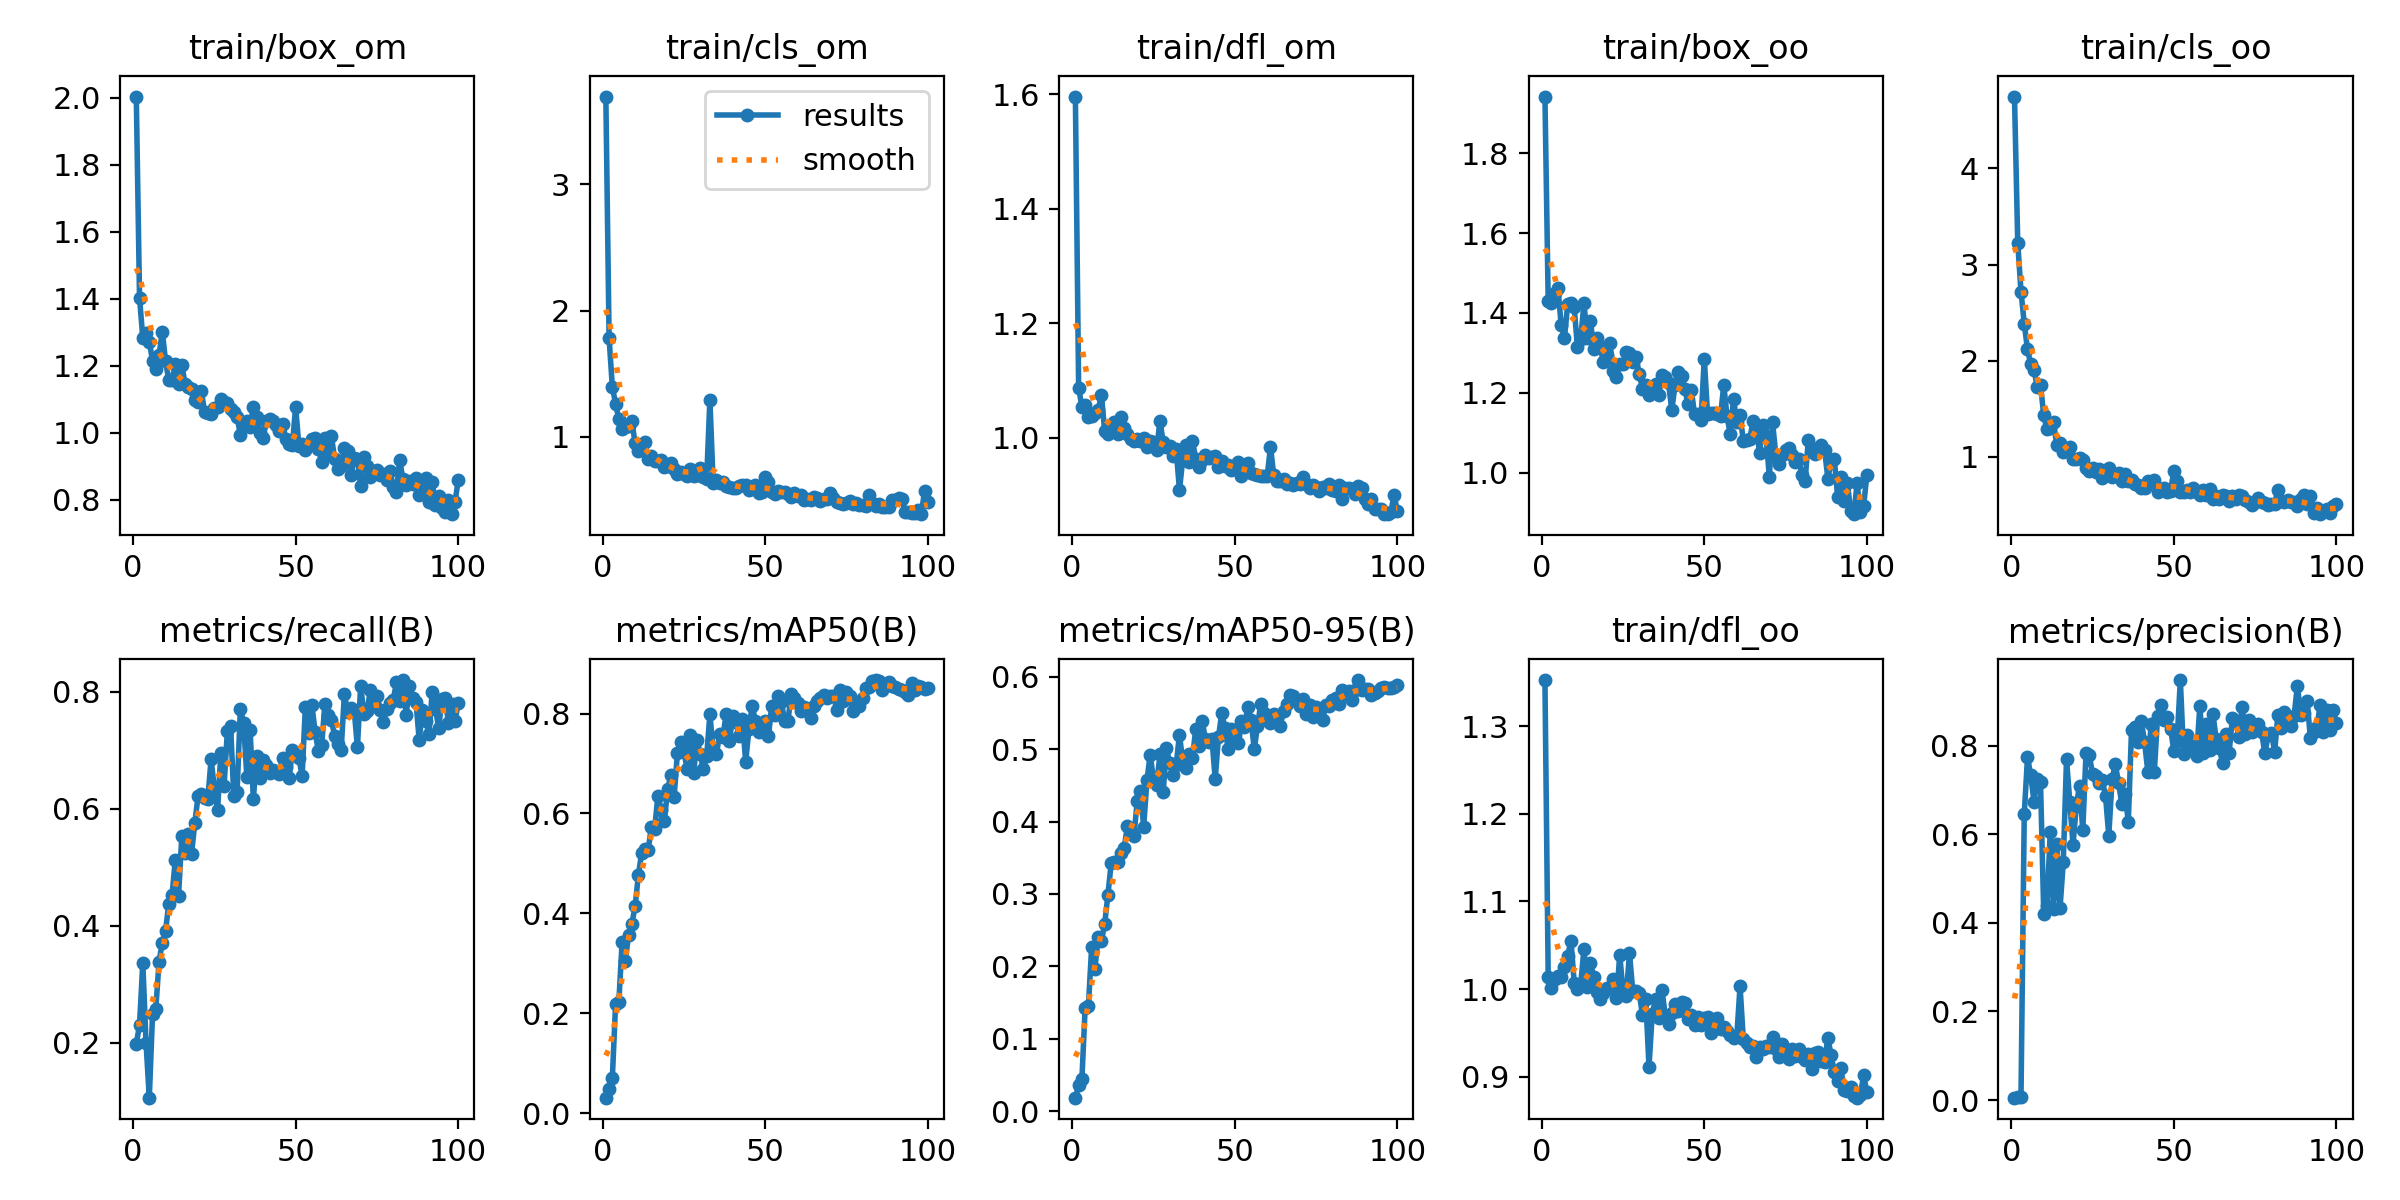

In [12]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited



0: 640x512 4 with_masks, 2 without_masks, 78.4ms
Speed: 5.0ms preprocess, 78.4ms inference, 125.3ms postprocess per image at shape (1, 3, 640, 512)


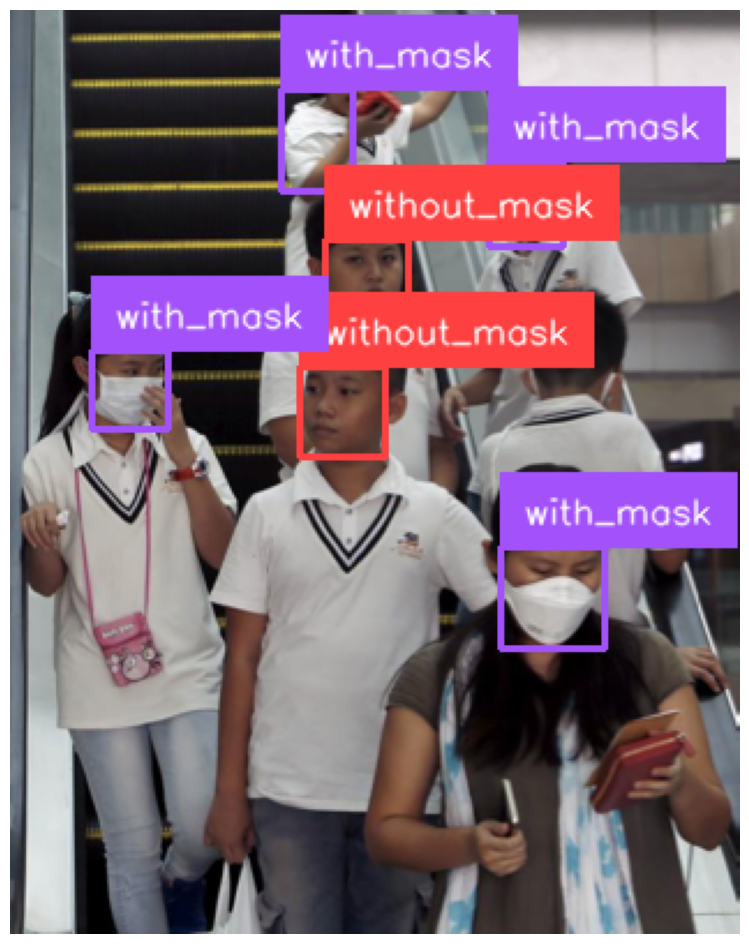

In [13]:
# Test the trained model and display an annotated test image
from ultralytics import YOLOv10
import supervision as sv
import random

# Load the trained model
model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

# Create a dataset object for the test set
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{HOME}/data/test/images",
    annotations_directory_path=f"{HOME}/data/test/labels",
    data_yaml_path=f"{HOME}/data/data.yaml"
)

# Set up annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Randomly select an image from the test set
random_item = random.choice(list(dataset))
random_image_path, random_image, _ = random_item

# Perform inference
results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

# Annotate the image
annotated_image = box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# Display the result
sv.plot_image(annotated_image)